(400, 640)
S:
8.19702528541
8.03998500815
8.0932429155
8.10488972542
8.22355952159
8.08572880736
7.74913297751
8.22100556662
8.12624896726
8.27863029718

T:
7.59145334721
7.21382702284
7.02899158144
7.182824444
7.16844727106
7.21382702284
7.28562613736
7.62160406251
7.61759262391
7.00988581284

V:
7.85827646186
7.90952926689
7.98707230247
7.96786903273
7.86237124503
7.97412921714
7.64548003527
7.83404573423
7.97129740689
7.9512974607



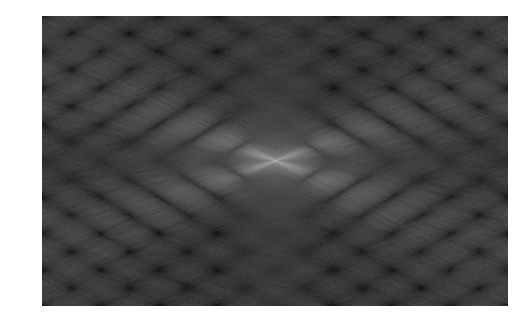

In [1]:


# for python 2 compatibility #
from __future__ import print_function
#                            #
import numpy as np
from skimage import io
from skimage.draw import polygon, circle
from skimage.transform import rotate
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import matplotlib as mpl
import scipy.misc
%matplotlib inline

letter_list = ['S', 'T', 'V']
k_number_of_images = 10
# get dummy image
avg_img = io.imread('test-data/S11.gif')

# convert to np.array so that we can compute the average  
avg_img_array = np.array(avg_img, dtype=float)
print(avg_img_array.shape)

for letter in letter_list:
    # reset np.array
    avg_img_array.fill(0)
    print(letter + ":")
    for image_index in range(1, k_number_of_images + 1):
        image_name = 'training-data/' + letter + str(image_index) + '.GIF'
        f = io.imread(image_name)   # read in image

        f_f = np.array(f, dtype=float)
        z = np.fft.fft2(f_f)           # do fourier transform
        q = np.fft.fftshift(z)         # puts u=0,v=0 in the centre

        Magq =  np.absolute(q)         # magnitude spectrum
        log_Magq = np.log(Magq + 1)
        log_Magq_array = np.array(log_Magq, dtype=float)
        
        for idx, pixel in enumerate(log_Magq_array):
            avg_img_array[idx] += pixel
        
        
        Phaseq = np.angle(q)           # phase spectrum

        image_avg_pixel_val = np.mean(log_Magq)
        print(image_avg_pixel_val)
        
    avg_img_array /= k_number_of_images
    
    scipy.misc.imsave(letter + '_avg.png', avg_img_array)
    
    print()

fig1 = plt.figure()
ax1  = fig1.add_subplot( 111 )
ax1.axis('off')
# Usually for viewing purposes:b
ax1.imshow( avg_img_array, cmap='gray' ) # io.

# fig1 = plt.figure()
# ax1  = fig1.add_subplot( 111 )
# ax1.axis('off')
# Usually for viewing purposes:
# ax1.imshow( np.log( np.absolute(q) + 1 ), cmap='gray' ) # io.

# w = np.fft.ifft2( np.fft.ifftshift(q) ) # do inverse fourier transform
#
# fig2 = plt.figure()
# ax2  = fig2.add_subplot( 111 )
# ax2.axis('off')
# ax2.imshow( np.array(w,dtype=int), cmap='gray' ) # io.

plt.show()

In [2]:
def euclidean_distance(A, B):
    return math.sqrt( (A[0] - B[0])**2 + (A[1] - B[1])**2 )

400 640


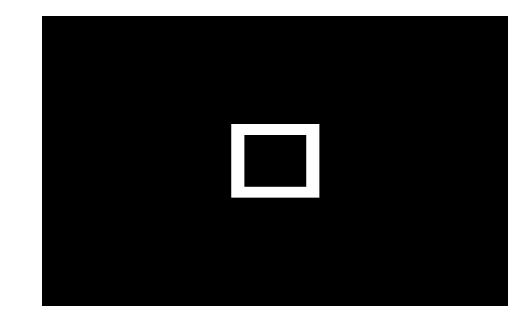

In [3]:
def box_filter( image_array, height, width, inner_height, inner_width ):
    filter_image_array = np.array(image_array, dtype=float)
    filter_image_array.fill(0)
    rows = image_array.shape[0]
    cols = image_array.shape[1]
    print(rows, cols)
    center = ( int(rows / 2), int(cols / 2) )
    top_left     = ( center[0] - int(height / 2), center[1] - int(width / 2) )
    bottom_right = ( center[0] + int(height / 2), center[1] + int(width / 2) )
    
    inner_top_left     = ( center[0] - int(inner_height / 2), center[1] - int(inner_width / 2) )
    inner_bottom_right = ( center[0] + int(inner_height / 2), center[1] + int(inner_width / 2) )

    for row in range(rows):
        if not (top_left[0] <= row and row <= bottom_right[0]):
            continue
        for col in range(cols):
            if top_left[1] <= col and col <= bottom_right[1]:
                if not (inner_top_left[1] <= col and col <= inner_bottom_right[1]) \
                    or (not (inner_top_left[0] <= row and row <= inner_bottom_right[0])):
                        filter_image_array[row][col] = True
                   
    fig1 = plt.figure()
    ax1  = fig1.add_subplot( 111 )
    ax1.axis('off')
    # Usually for viewing purposes:b
    ax1.imshow( filter_image_array, cmap='gray' ) # io.
    scipy.misc.imsave('filters/box-filter.png', filter_image_array)
    plt.show()
    

box_filter( avg_img_array, 100, 120, 70, 84 )

In [4]:
def draw_squashed_rekt(bottom_left, w, h, r, colour=1):
    img = np.zeros((400, 640), dtype=float)

    rows = img.shape[0]
    cols = img.shape[1]
    print(rows, cols)
    center = ( int(cols / 2), int(rows / 2) )
    top_left = (bottom_left[0] - h - h/4, bottom_left[1] - w/4)
    bottom_right = (bottom_left[0] + h/4, bottom_left[1] + w + w/4)
    top_right = (bottom_left[0] - h, bottom_left[1] + w)
    
    X = [top_left[0],  top_right[0],  bottom_right[0], bottom_left[0]]
    Y = [top_left[1],  top_right[1],  bottom_right[1], bottom_left[1]]
    
    x = np.array(X)
    y = np.array(Y)
    rr, cc = polygon(x, y)
    img[rr, cc] = colour
    img = rotate(img, r, center=center, preserve_range=True)
    return img

400 640
400 640
400 640


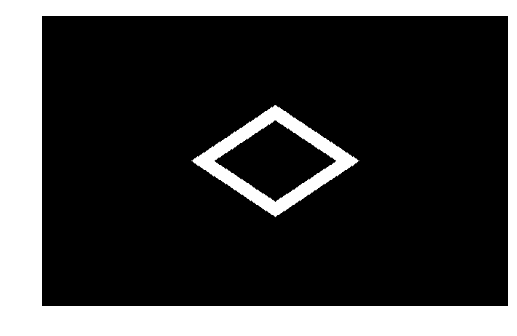

In [5]:
def rotated_box_filter( image_array, height, width, inner_height, inner_width ):
    filter_image_array = np.array(image_array, dtype=float)
    filter_image_array.fill(0)
    rows = image_array.shape[0]
    cols = image_array.shape[1]
    print(rows, cols)
    center = ( int(rows / 2), int(cols / 2) )
#     top_left     = ( center[0] - int(height / 2), center[1] - int(width / 2) )
#     bottom_right = ( center[0] + int(height / 2), center[1] + int(width / 2) )
    
#     inner_top_left     = ( center[0] - int(inner_height / 2), center[1] - int(inner_width / 2) )
#     inner_bottom_right = ( center[0] + int(inner_height / 2), center[1] + int(inner_width / 2) )

    bottom_left = ( center[0] + int(height / 2), center[1] - int(width / 2) )
    inner_bottom_left = ( center[0] + int(inner_height / 2), center[1] - int(inner_width / 2) )

    outer_rekt = draw_squashed_rekt(bottom_left, width, height, 45)
    inner_rekt = draw_squashed_rekt(inner_bottom_left, inner_width, inner_height, 45)
    result_img = np.array(avg_img_array, dtype=float)
    result_img.fill(0)
    for row in range(result_img.shape[0]):
        for col in range(result_img.shape[1]):
            if outer_rekt[row][col] == True:
                result_img[row][col] = True
                
            if inner_rekt[row][col] == True:
                result_img[row][col] = False
    
    scipy.misc.imsave('filters/rotated-box-filter.png', result_img)

    fig1 = plt.figure()
    ax1  = fig1.add_subplot( 111 )
    ax1.axis('off')
    # Usually for viewing purposes:b
    ax1.imshow( result_img, cmap='gray' ) # io.
    plt.show()
    

rotated_box_filter( avg_img_array, 110, 110, 80, 80 )

400 640
(200, 320)
134.536240471


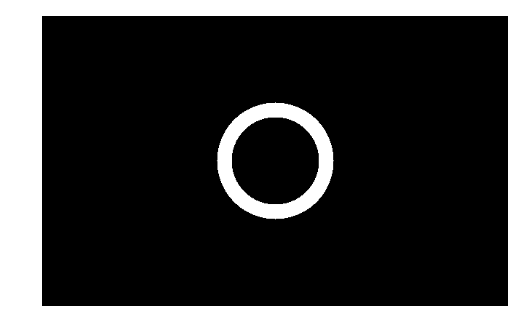

In [6]:
def ring_filter( image_array, radius_outter, radius_inner ):
    filter_image_array = np.array(image_array, dtype=float)
    filter_image_array.fill(0)
    rows = image_array.shape[0]
    cols = image_array.shape[1]
    print( rows, cols )
    center = ( int(rows / 2), int(cols / 2) )
    print( center )
    
    print(np.linalg.norm([100, 230] - np.asarray(center)))
    
    for row in range(rows):
        if not (center[0] - radius_outter <= row and row <= center[0] + radius_outter):
            continue
        for col in range(cols):
            if center[1] - radius_outter <= col and col <= center[1] + radius_outter:
                if np.linalg.norm([row, col] - np.asarray(center)) <= radius_outter:
                    if radius_inner <= np.linalg.norm([row, col] - np.asarray(center)):
                        filter_image_array[row][col] = True

    fig1 = plt.figure()
    ax1  = fig1.add_subplot( 111 )
    ax1.axis('off')
    # Usually for viewing purposes:b
    ax1.imshow( filter_image_array, cmap='gray' ) # io.
    scipy.misc.imsave('filters/ring-filter.png', filter_image_array)
    plt.show()
    
ring_filter( avg_img_array, 80, 60 )

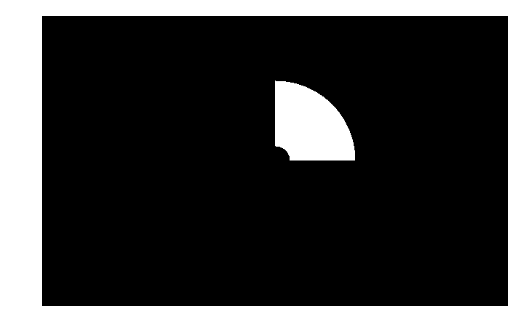

In [7]:
'''
Returns a grayscale image representing a sector filter.

Parameters
----------
    radius  : radius of the sector. 

    theta_1 : the angle between the Ox axis and the right side of the sector.
    
    theta_2 : the angle between the Ox axis and the left side of the sector.
'''
def sector_filter( image_array, radius, theta_1, theta_2, inner_circle_radius=0):
    filter_image_array = np.array(image_array, dtype=float)
    filter_image_array.fill(0)
    rows = image_array.shape[0]
    cols = image_array.shape[1]
    
    center = ( int(rows / 2), int(cols / 2) )
    
    for row in range(rows):
        # Flip the graph by the Ox axis.
        translated_row = -(row - center[0])
        # To avoid division by zero in the computation of atan below.
        if translated_row == 0 or translated_row < 0:
            continue
        for col in range(cols):
            translated_col = col - center[1]
            if (translated_row)**2 + (translated_col)**2 > radius**2:
                continue
            # Inner circle
            dist = euclidean_distance((0, 0), (translated_row, translated_col))
            if dist <= inner_circle_radius:
                continue
            arctg_degrees = math.degrees(math.atan( translated_col / translated_row ) )
            if theta_1 <= arctg_degrees and arctg_degrees <= theta_2:
                # Mark the original, untranslated pixel.
                filter_image_array[row][col] = True
                
    fig1 = plt.figure()
    ax1  = fig1.add_subplot( 111 )
    ax1.axis('off')
    # Usually for viewing purposes:b
    ax1.imshow( filter_image_array, cmap='gray' ) # io.
    scipy.misc.imsave('filters/sector-filter.png', filter_image_array)
    plt.show()
    
sector_filter( avg_img_array, 110, 0, 90, 20 )

In [8]:
def draw_rekt(bottom_left, w, h, r, colour=1):
    img = np.zeros((400, 640), dtype=float)

    rows = img.shape[0]
    cols = img.shape[1]
    print(rows, cols)
    center = ( int(cols / 2), int(rows / 2) )
    top_left = (bottom_left[0] - h, bottom_left[1])
    bottom_right = (bottom_left[0], bottom_left[1] + w)
    top_right = (top_left[0], top_left[1] + w)
    
    X = [top_left[0],  top_right[0],  bottom_right[0], bottom_left[0]]
    Y = [top_left[1],  top_right[1],  bottom_right[1], bottom_left[1]]
    
    x = np.array(X)
    y = np.array(Y)
    rr, cc = polygon(x, y)
    img[rr, cc] = colour
    img = rotate(img, r, center=center, preserve_range=True)
    return img


400 640
400 640
400 640
400 640
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


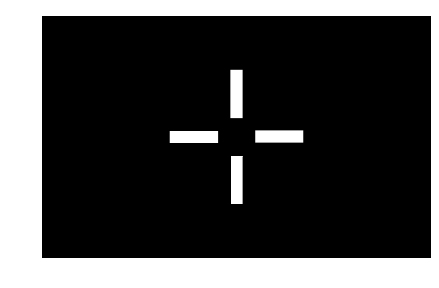

In [9]:
fig1 = plt.figure(figsize=(5, 8), dpi=80)
ax1  = fig1.add_subplot( 111 )
ax1.axis('off')


rekt_bottom_left = (170, 310) # TODO: Might need adjusting.
hands = []
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 0)
hands.append(curr_hand)
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 90)
hands.append(curr_hand)
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 180)
hands.append(curr_hand)
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 270)
hands.append(curr_hand)

result_img = np.array(avg_img_array, dtype=float)
result_img.fill(0)
for row in range(result_img.shape[0]):
    for col in range(result_img.shape[1]):
        for hand in hands:
            if hand[row][col] == True:
                result_img[row][col] = True
# test_img = cross((180, 300), 40, 80, 90)
print(result_img)
ax1.imshow( result_img, cmap='gray' ) # io.
# plt.savefig('plus-filter.png')
scipy.misc.imsave('filters/plus-filter.png', result_img)
plt.show()

400 640
400 640
400 640
400 640
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


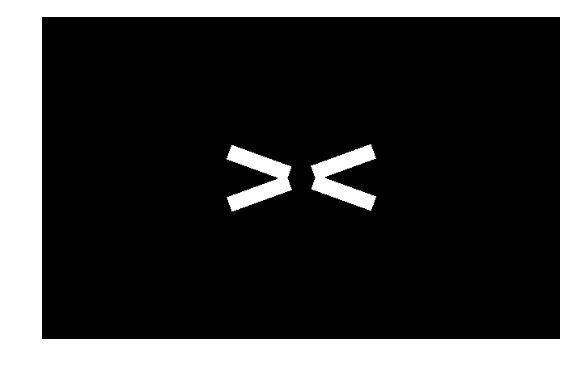

In [10]:
fig1 = plt.figure(figsize=(640/96, 400/96), dpi=96)
ax1  = fig1.add_subplot( 111 )
ax1.axis('off')


rekt_bottom_left = (185, 310)
hands = []
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 70)
hands.append(curr_hand)
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 110)
hands.append(curr_hand)
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 250)
hands.append(curr_hand)
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 290)
hands.append(curr_hand)

result_img = np.array(avg_img_array, dtype=float)
result_img.fill(0)
for row in range(result_img.shape[0]):
    for col in range(result_img.shape[1]):
        for hand in hands:
            if hand[row][col] == True:
                result_img[row][col] = True
# test_img = cross((180, 300), 40, 80, 90)
print(result_img)
ax1.imshow( result_img, cmap='gray' ) # io.
# plt.savefig('cross-filter.png', dpi=96)

scipy.misc.imsave('filters/cross-filter.png', result_img)

plt.show()

13


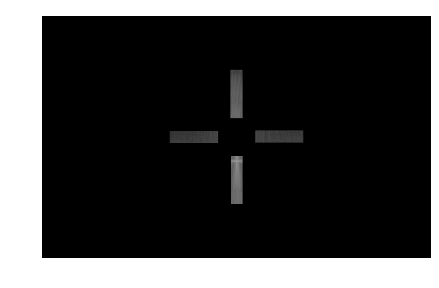

In [11]:
filter_name = 'filters/plus-filter.png'
filter_image = io.imread(filter_name)   # read in image
letter_image = io.imread('T_test_avg.png')
filtered_letter_image = np.array(filter_image, dtype=float)
filtered_letter_image.fill(0)

filter_array = np.array(filter_image, dtype=float)
# filtered_letter_image = np.array(filter_image, dtype=float)
print(letter_image[10][10])
rows, cols = filter_image.shape

f_f = np.array(letter_image, dtype=float)
z = np.fft.fft2(f_f)           # do fourier transform
q = np.fft.fftshift(z)         # puts u=0,v=0 in the centre

Magq =  np.absolute(q)         # magnitude spectrum
log_Magq = np.log(Magq + 1)
log_Magq_array = np.array(log_Magq, dtype=float)

Phaseq = np.angle(q)           # phase spectrum

for row in range(rows):
    for col in range(cols):
        if filter_array[row][col]:
            filtered_letter_image[row][col] = letter_image[row][col]
            
fig1 = plt.figure(figsize=(5, 8), dpi=80)
ax1  = fig1.add_subplot( 111 )
ax1.axis('off')
ax1.imshow( filtered_letter_image, cmap='gray' ) # io.
scipy.misc.imsave('mix_test_T.png', filtered_letter_image)
plt.show()


In [12]:
def get_average_brightness_value_on_filtered_image(letter_image, filter_image):
    filtered_letter_image = np.array(filter_image, dtype=float)
    filtered_letter_image.fill(0)

    filter_array = np.array(filter_image, dtype=float)
    rows, cols = filter_image.shape

    f_f = np.array(letter_image, dtype=float)
    z = np.fft.fft2(f_f)           # do fourier transform
    q = np.fft.fftshift(z)         # puts u=0,v=0 in the centre

    Magq =  np.absolute(q)         # magnitude spectrum
    log_Magq = np.log(Magq + 1)
    log_Magq_array = np.array(log_Magq, dtype=float)

    Phaseq = np.angle(q)           # phase spectrum

    result_avg = 0
    filter_pixels = 0
    for row in range(rows):
        for col in range(cols):
            if filter_array[row][col]:
                result_avg += log_Magq_array[row][col]
                filter_pixels += 1
#                 filtered_letter_image[row][col] = log_Magq_array[row][col]
    
    result_avg /= filter_pixels
    return result_avg

In [13]:
def apply_filters(is_training=True):
    
    
    letter_list = ['S', 'T', 'V']
    
    filter_names = ['rotated-box-filter.png', 
                    'cross-filter.png', 
                    'plus-filter.png', 
                    'ring-filter.png',
                    'sector-filter.png']

    
    if is_training:
        data_folder = 'training-data/'
        k_number_of_images = 10
        image_prefix = ''
        image_suffix = '.GIF'
        matrix = np.zeros(shape=(30, 5))
    else:
        data_folder = 'test-data/'
        k_number_of_images = 8
        image_prefix = '1'
        image_suffix = '.gif'
        matrix = np.zeros(shape=(24, 5))
    
    for letter_idx, letter in enumerate(letter_list):
        print("letter idx ", letter_idx)
        print("Processing " + letter + ":")
        for image_idx in range(1, k_number_of_images + 1):
            print(image_idx)
            image_name = data_folder + letter + image_prefix + str(image_idx) + image_suffix
            letter_image = io.imread(image_name)   # read in image
            for filter_idx, filter_name in enumerate(filter_names):
                filter_image = io.imread('filters/' + filter_name)   # read in image
                avg_brightness = get_average_brightness_value_on_filtered_image(letter_image, filter_image)
                matrix[letter_idx * k_number_of_images + image_idx - 1][filter_idx] = avg_brightness

    return matrix

In [14]:
# Get the training data images and the test data images and apply the filters.
training_data_matrix = apply_filters()
test_data = apply_filters(False)

letter idx  0
Processing S:
1
2
3
4
5
6
7
8
9
10
letter idx  1
Processing T:
1
2
3
4
5
6
7
8
9
10
letter idx  2
Processing V:
1
2
3
4
5
6
7
8
9
10
letter idx  0
Processing S:
1
2
3
4
5
6
7
8
letter idx  1
Processing T:
1
2
3
4
5
6
7
8
letter idx  2
Processing V:
1
2
3
4
5
6
7
8


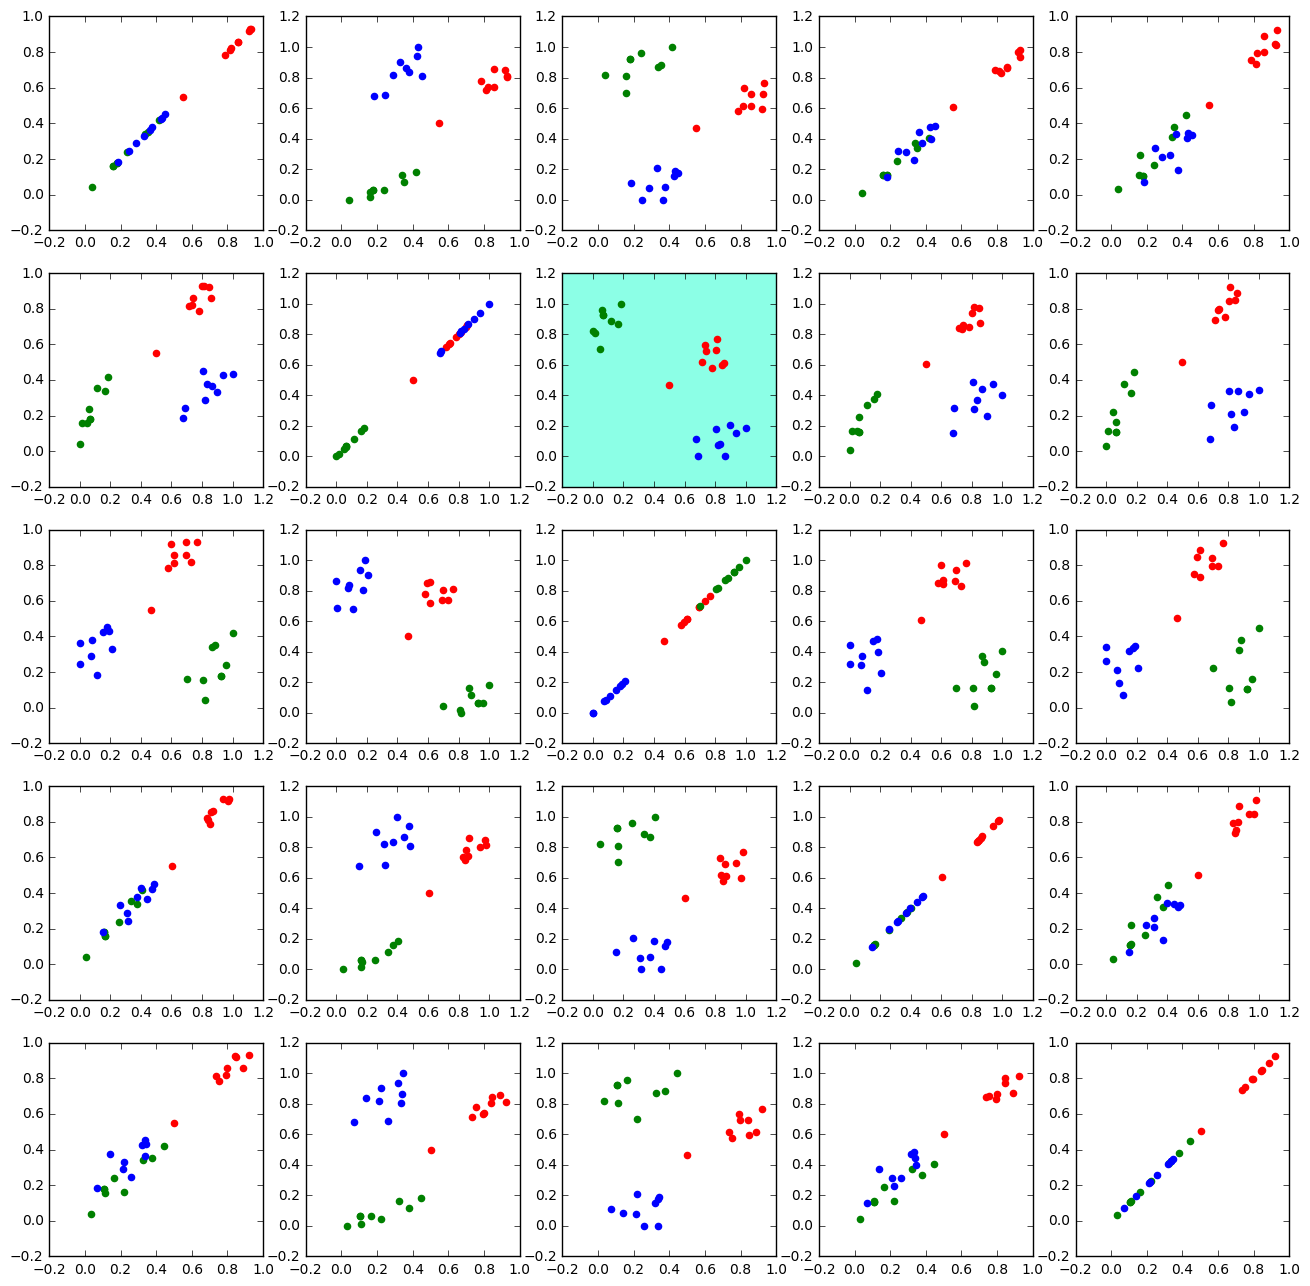

In [15]:
def plotmatrix(Matrix):
    r, c = Matrix.shape
    fig = plt.figure(figsize=(16, 16), dpi=80)
    plotID = 1
    for i in range(c):
        for j in range(c):
            ax = fig.add_subplot( c, c, plotID )
            ax.scatter( Matrix[0:9,i], Matrix[0:9,j], color="r" )
            ax.scatter( Matrix[10:19,i], Matrix[10:19,j], color="g" )
            ax.scatter( Matrix[20:29,i], Matrix[20:29,j], color="b" )
            
            plotID += 1
            if (i == 1 and j == 2):
                ax.set_axis_bgcolor((0.55, 1, 0.9))
#     fig.suptitle('Training Data Scatter Plot Matrix', fontsize=60)
    plt.savefig('feature-grid.png')
    plt.show()
    

# Feature scaling normalization, i.e. X' = ()/ ()
max_normalizing_term = np.amax(training_data_matrix, axis=0)
min_normalizing_term = np.amin(training_data_matrix, axis=0)
training_data_matrix = np.divide(training_data_matrix - min_normalizing_term, 
                                 max_normalizing_term - min_normalizing_term)

# test_data_normalizing_term = np.amax(test_data, axis=0)
test_data = np.divide(test_data - min_normalizing_term, 
                      max_normalizing_term - min_normalizing_term)

plotmatrix(training_data_matrix)


In [16]:
from sklearn.neighbors import NearestNeighbors
X = np.asmatrix(np.column_stack((training_data_matrix[:,1], training_data_matrix[:,2])))
# print(X)
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X)


In [17]:
test_data_matrix = np.asmatrix(np.column_stack((test_data[:,1], test_data[:,2])))
distances, indices = nbrs.kneighbors(test_data_matrix)

print(test_data_matrix)
# print(test_data_matrix)
# print(indices)  
# print(distances)

[[ 0.62383806  0.73594451]
 [ 0.64245831  0.69963589]
 [ 0.44405669  0.53532748]
 [ 0.68150857  0.67702755]
 [ 0.58479145  0.60674462]
 [ 0.32030448  0.38462715]
 [ 0.66332753  0.58500305]
 [ 0.62034132  0.41657276]
 [-0.05198216  0.96417216]
 [ 0.10878262  0.95914234]
 [-0.06532287  0.78186536]
 [ 0.00944474  0.8423543 ]
 [ 0.01598983  0.85429574]
 [-0.04596803  0.79535636]
 [-0.03472272  0.54149133]
 [ 0.02284768  0.79889442]
 [ 0.68412659  0.19425396]
 [ 0.81382881  0.09111878]
 [ 0.85574336 -0.03924125]
 [ 0.73180125 -0.11898674]
 [ 0.69772181 -0.032972  ]
 [ 0.43966278  0.12932077]
 [ 0.76323843 -0.15529032]
 [ 0.53649786  0.05110538]]


[[ 0.62383806  0.73594451]
 [ 0.64245831  0.69963589]
 [ 0.44405669  0.53532748]
 [ 0.68150857  0.67702755]
 [ 0.58479145  0.60674462]
 [ 0.32030448  0.38462715]
 [ 0.66332753  0.58500305]
 [ 0.62034132  0.41657276]
 [-0.05198216  0.96417216]
 [ 0.10878262  0.95914234]
 [-0.06532287  0.78186536]
 [ 0.00944474  0.8423543 ]
 [ 0.01598983  0.85429574]
 [-0.04596803  0.79535636]
 [-0.03472272  0.54149133]
 [ 0.02284768  0.79889442]
 [ 0.68412659  0.19425396]
 [ 0.81382881  0.09111878]
 [ 0.85574336 -0.03924125]
 [ 0.73180125 -0.11898674]
 [ 0.69772181 -0.032972  ]
 [ 0.43966278  0.12932077]
 [ 0.76323843 -0.15529032]
 [ 0.53649786  0.05110538]]


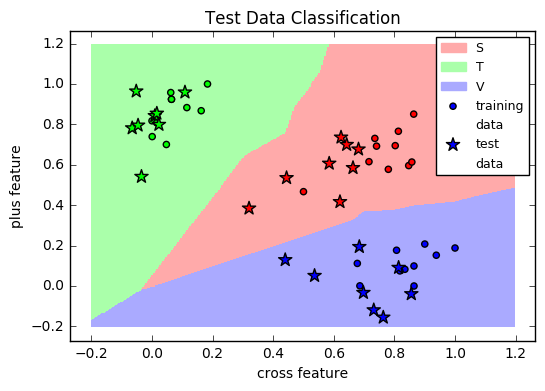

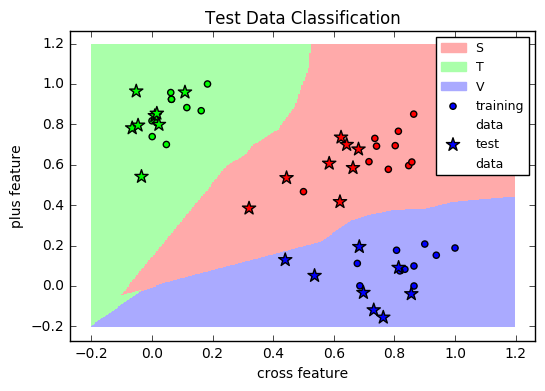

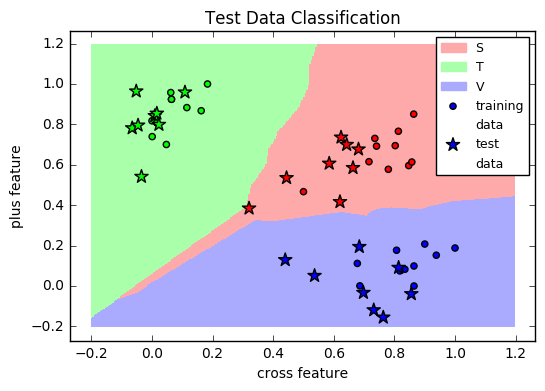

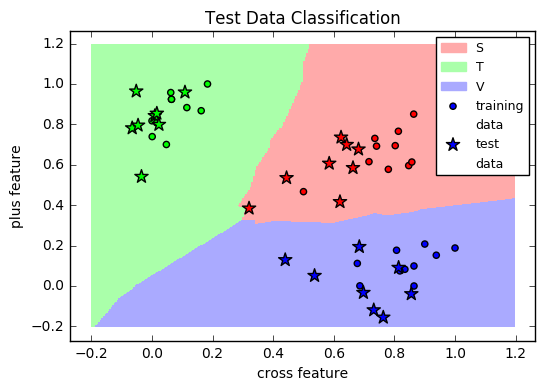

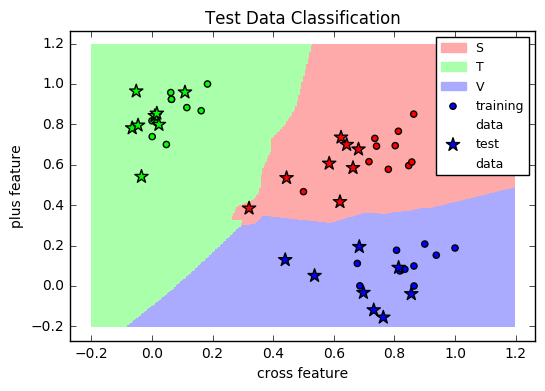

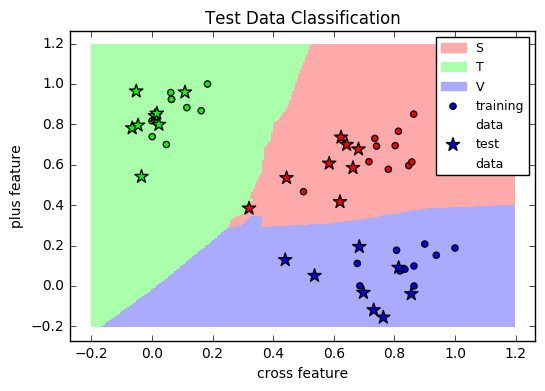

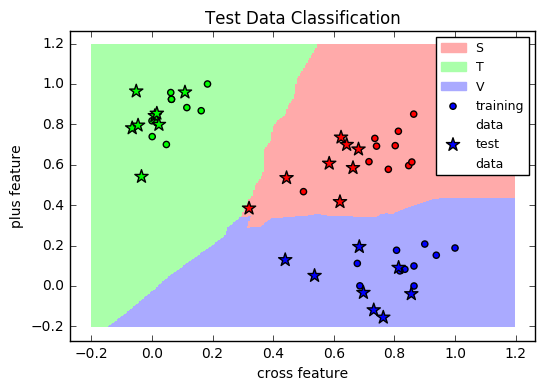

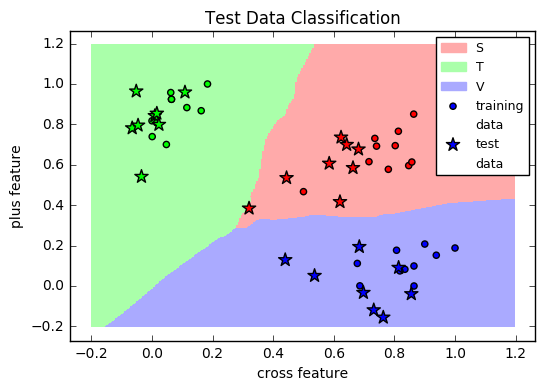

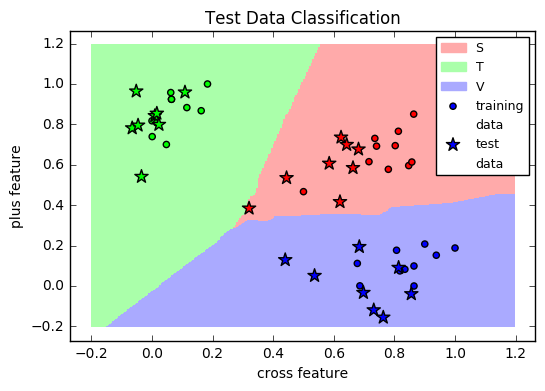

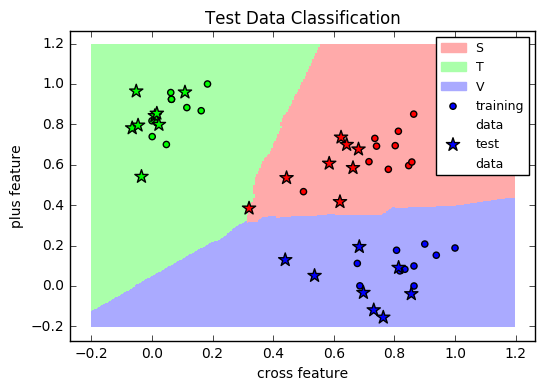

In [90]:
n_neighbors = 1
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
# import some data to play with

y = [int(x / 10) for x in range(30)] # target labeling
y_test = [int(x / 8) for x in range(24)] # target labeling
# print(X)
# print(y)
print(test_data_matrix)
# print()
h = .005  # step size in the mesh



# Create color maps
# cmap_light = ListedColormap(['#FFFF00', '#0000FF', '#FF0000'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# we create an instance of Neighbours Classifier and fit the data.
for n_neighbors in range(1, 11):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X, y)
    y_pred = clf.predict(X)
#     print(shrinkage, np.mean(y == y_pred))
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    train = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    test = plt.scatter(test_data_matrix[:, 0], test_data_matrix[:, 1], s=100, c=y_test, cmap=cmap_bold, marker='*')
    
#     if n_neighbors == 1:
#         plt.title("Nearest Neighbour Classification")
#     else:
#         plt.title(str(n_neighbors) + "-Nearest Neighbour Classification")
    plt.title("Test Data Classification")
    plt.axis('tight')
    
    ax.set_ylabel('plus feature')
    ax.set_xlabel('cross feature')
    
    S_patch = patches.Patch(color='#FFAAAA', label='S')
    T_patch = patches.Patch(color='#AAFFAA', label='T')
    V_patch = patches.Patch(color='#AAAAFF', label='V')
    
    W_patch = patches.Patch(color='#FFFFFF')
    
    plt.legend((S_patch, T_patch, V_patch, train, W_patch, test, W_patch), 
               ('S', 'T', 'V', 'training', 'data', 'test', 'data'), 
               scatterpoints=1,
               loc='upper right',
               fontsize=9)
#     plt.savefig(str(n_neighbors) + 'nnclassigication_test.png')
    
#     axes = plt.gca()
#     axes.set_xlim([0,1.1])
#     axes.set_ylim([0,1.1])

plt.show()

(0.0, 1.0, 0.0, 1.0)

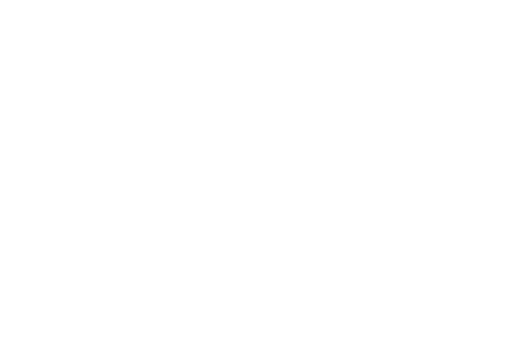

In [91]:
from skimage import io
image_name = 'training-data/T1.GIF'
f = io.imread(image_name)   # read in image

f_f = np.array(f, dtype=float)
z = np.fft.fft2(f_f)           # do fourier transform
q = np.fft.fftshift(z)         # puts u=0,v=0 in the centre
# print(q)

Magq =  np.absolute(q)         # magnitude spectrum
log_Magq = np.log(Magq + 1)
log_Magq_array = np.array(log_Magq, dtype=float)

Phaseq = np.angle(q)           # phase spectrum

# image_avg_pixel_val = np.mean(log_Magq)
# print(log_Magq)

# scipy.misc.imsave('S16_magnitude_spectrum.png', log_Magq_array)

fig1 = plt.figure()
ax1  = fig1.add_subplot( 111 )
ax1.axis('off')
# Usually for viewing purposes:b
# ax1.imshow( log_Magq_array[180:220][300:340], cmap='gray' ) # io.

In [20]:
def apply_filters_a_b():
    
    
    letter_list = ['A', 'B']
    
    filter_names = ['rotated-box-filter.png', 
                    'cross-filter.png', 
                    'plus-filter.png', 
                    'ring-filter.png',
                    'sector-filter.png']
    
    data_folder = 'test-data/'
    k_number_of_images = 1
    image_suffix = '.GIF'
    matrix = np.zeros(shape=(2, 5))
    
    for letter_idx, letter in enumerate(letter_list):
        print("letter idx ", letter_idx)
        print("Processing " + letter + ":")
        for image_idx in range(1, k_number_of_images + 1):
            print(image_idx)
            image_name = data_folder + letter + str(image_idx) + image_suffix
            letter_image = io.imread(image_name)   # read in image
            for filter_idx, filter_name in enumerate(filter_names):
                filter_image = io.imread('filters/' + filter_name)   # read in image
                avg_brightness = get_average_brightness_value_on_filtered_image(letter_image, filter_image)
                matrix[letter_idx * k_number_of_images + image_idx - 1][filter_idx] = avg_brightness

    return matrix

In [21]:
a_b_data = apply_filters_a_b()
a_b_data = np.divide(a_b_data - min_normalizing_term, 
                      max_normalizing_term - min_normalizing_term)
a_b_data_matrix = np.asmatrix(np.column_stack((a_b_data[:,1], a_b_data[:,2])))
print(a_b_data_matrix)

letter idx  0
Processing A:
1
letter idx  1
Processing B:
1
[[ 0.8354722   0.63851027]
 [ 0.67051036  0.93214252]]


[[ 0.8354722   0.63851027]
 [ 0.67051036  0.93214252]]


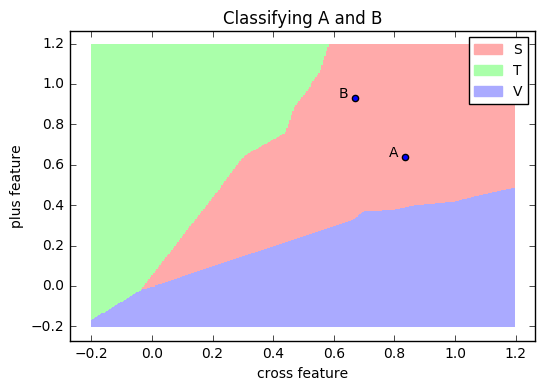

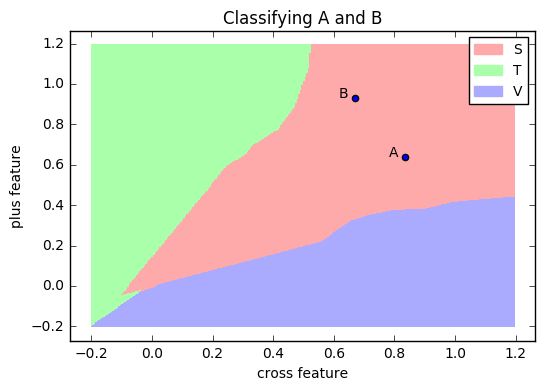

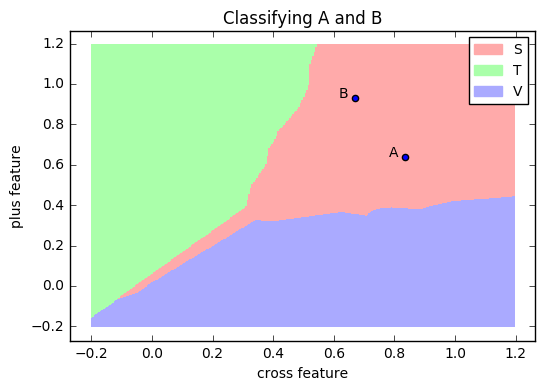

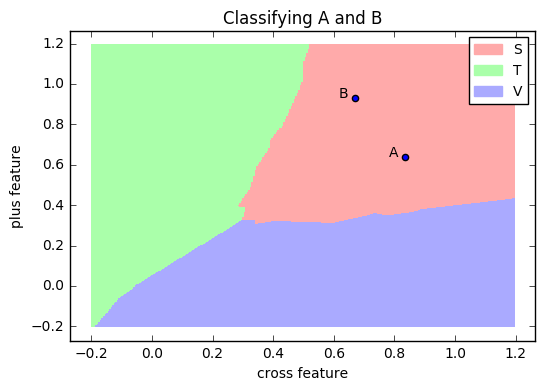

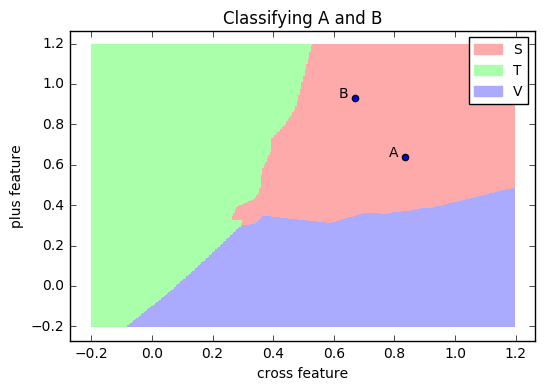

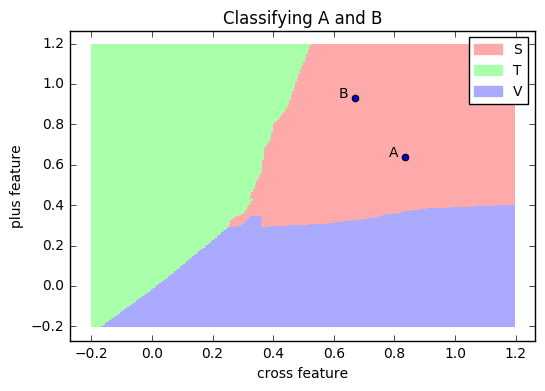

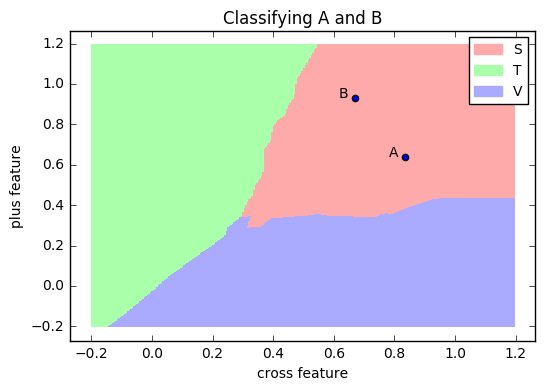

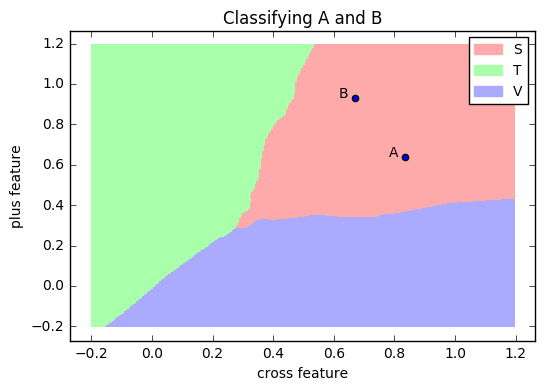

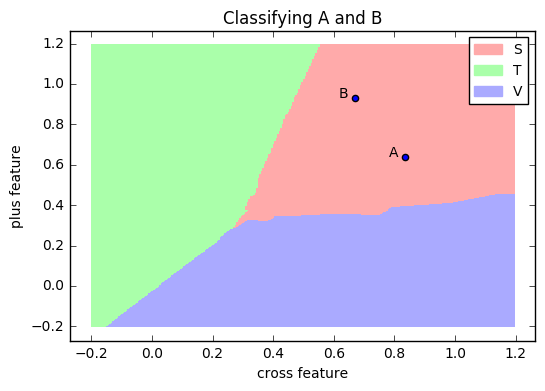

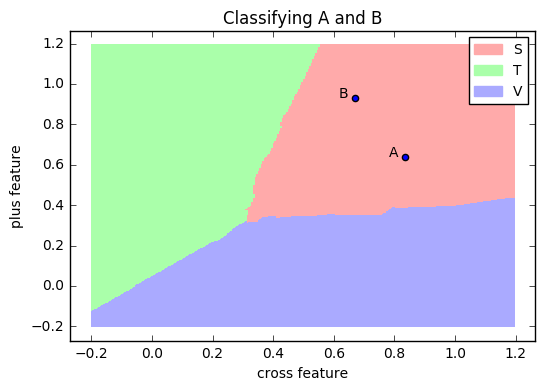

In [94]:
n_neighbors = 1
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
# import some data to play with

y = [int(x / 10) for x in range(30)] # target labeling
# y_test = [int(x / 8) for x in range(24)] # target labeling
# print(X)
# print(y)
# print(test_data_matrix)
print(a_b_data_matrix)
h = .005  # step size in the mesh

# Create color maps
# cmap_light = ListedColormap(['#FFFF00', '#0000FF', '#FF0000'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# we create an instance of Neighbours Classifier and fit the data.
for n_neighbors in range(1, 11):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X, y)
    y_pred = clf.predict(X)
#     print(shrinkage, np.mean(y == y_pred))
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
#     plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.scatter(a_b_data_matrix[:, 0], a_b_data_matrix[:, 1])
    plt.annotate('A', xy=(a_b_data_matrix[0, 0], a_b_data_matrix[0, 1]), xytext=(-12, 0), textcoords='offset points')
    plt.annotate('B', xy=(a_b_data_matrix[1, 0], a_b_data_matrix[1, 1]), xytext=(-12, 0), textcoords='offset points')
    
    plt.title("Classifying A and B")
    plt.axis('tight')
    
    S_patch = patches.Patch(color='#FFAAAA', label='S')
    T_patch = patches.Patch(color='#AAFFAA', label='T')
    V_patch = patches.Patch(color='#AAAAFF', label='V')
    plt.legend(handles=[S_patch, T_patch, V_patch], fontsize=10)
    
    ax.set_ylabel('plus feature')
    ax.set_xlabel('cross feature')
    plt.savefig(str(n_neighbors) + 'nnclassigication_a_b.png')
    
#     axes = plt.gca()
#     axes.set_xlim([0,1.1])
#     axes.set_ylim([0,1.1])

plt.show()

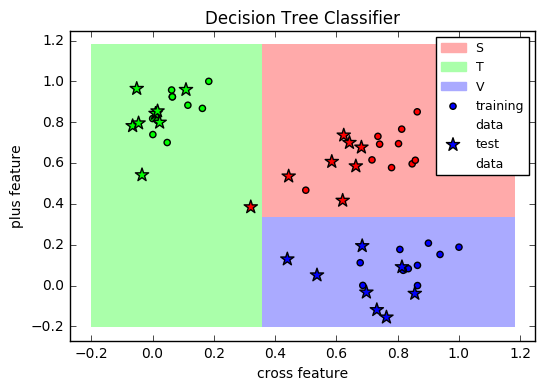

In [92]:
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
plot_colors = "bry"
plot_step = 0.02

# print(X)

clf = DecisionTreeClassifier(splitter='best').fit(X, y)

x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

train = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
test = plt.scatter(test_data_matrix[:, 0], test_data_matrix[:, 1], s=100, c=y_test, cmap=cmap_bold, marker='*')

plt.axis("tight")
ax.set_ylabel('plus feature')
ax.set_xlabel('cross feature')

S_patch = patches.Patch(color='#FFAAAA', label='S')
T_patch = patches.Patch(color='#AAFFAA', label='T')
V_patch = patches.Patch(color='#AAAAFF', label='V')

W_patch = patches.Patch(color='#FFFFFF')

plt.legend((S_patch, T_patch, V_patch, train, W_patch, test, W_patch), 
           ('S', 'T', 'V', 'training', 'data', 'test', 'data'), 
           scatterpoints=1,
           loc='upper right',
           fontsize=9)

plt.title("Decision Tree Classifier")

plt.savefig('dtClassifier.png')

plt.show()

In [93]:
import pydotplus 
import io
from sklearn import tree
from IPython.display import Image  

# X1 = np.asmatrix(np.column_stack((training_data_matrix[:,0], training_data_matrix[:,3], training_data_matrix[:,4])))
# ft = DecisionTreeClassifier().fit(X1, y)
tree.export_graphviz(clf, 
                     out_file='decisionTree.dot', 
                     feature_names=['cross-filter', 'plus-filter'],  
                     class_names=['S', 'T', 'V']) 
# tree.export_graphviz(clf, out_file=dot_data)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write('w.jpg', format='jpg')
# print(dot_data)
# graph.write_pdf("iris.png")
# graph = pydotplus.graph_from_dot_data(dotfile) 
# graph.write_pdf("iris.pdf") 